In [1]:
import collections
import functools
import statistics
from typing import Callable, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
 * [Substep: EDA](#Substep:-EDA)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-7)
- [Step 8](#Step-8)
- [Step 9](#Step-9)
- [Step 10](#Step-10)

In [2]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
# disclaimer: may not work as is in Windows OS
# dataset source: https://grouplens.org/datasets/movielens/
!wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

--2022-03-20 13:49:13--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   330KB/s    in 2.9s    

2022-03-20 13:49:17 (330 KB/s) - ‘data/ml-latest-small.zip’ saved [978202/978202]



In [4]:
# disclaimer: may not work as is in Windows OS
# if `unzip` does not exist in your system: apt-get install unzip
!unzip -o data/ml-latest-small.zip -d data/

Archive:  data/ml-latest-small.zip
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  


## Step 1

In [5]:
# Formulate the optimization problem (similarly to the formulation in Unit 5). Your
# optimization problem will relate to the prediction error in the training dataset.
# Make sure you understand the unknowns of the problem, and what you are trying to optimize.

## Step 2 + Step 3

In [6]:
reader = Reader(
    line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5)
)

In [7]:
data = Dataset.load_from_file("data/ml-latest-small/ratings.csv", reader=reader)

#### Substep: EDA

In [8]:
movielens = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    names=["user", "item", "rating", "timestamp"],
    skiprows=1,
)

inspect_df(movielens)

shape: (100836, 4)


,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
movielens[movielens["rating"].isin([0.5, 1.5, 2.5, 3.5, 4.5])]

,user,item,rating,timestamp
234,2,1704,4.5,1445715228
237,2,8798,3.5,1445714960
240,2,58559,4.5,1445715141
242,2,68157,4.5,1445715154
247,2,80489,4.5,1445715340
...,...,...,...,...
100820,610,160341,2.5,1479545749
100821,610,160527,4.5,1479544998
100826,610,162350,3.5,1493849971
100827,610,163937,3.5,1493848789


In [10]:
print(f"number of users: {len(movielens['user'].unique())}")

number of users: 610


In [11]:
print(f"number of items: {len(movielens['item'].unique())}")

number of items: 9724


In [12]:
movielens["created_at"] = pd.to_datetime(movielens["timestamp"], unit="s")
movielens["created_at"] = pd.to_datetime(movielens["created_at"], format="%Y-%m")

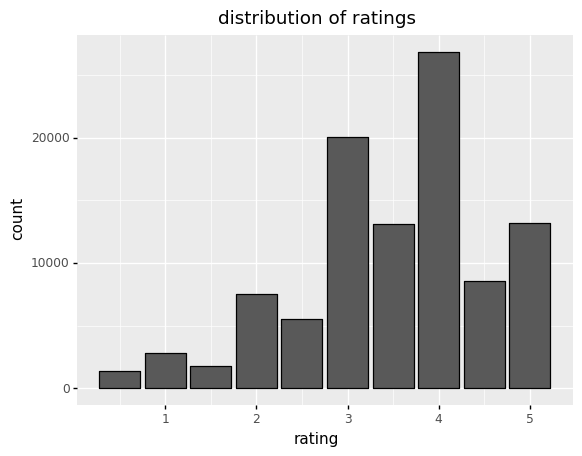

<ggplot: (8786730953063)>

In [13]:
(
    ggplot(movielens, aes(x="rating"))
    + geom_bar(color="black")
    + labs(x="rating", title="distribution of ratings")
)

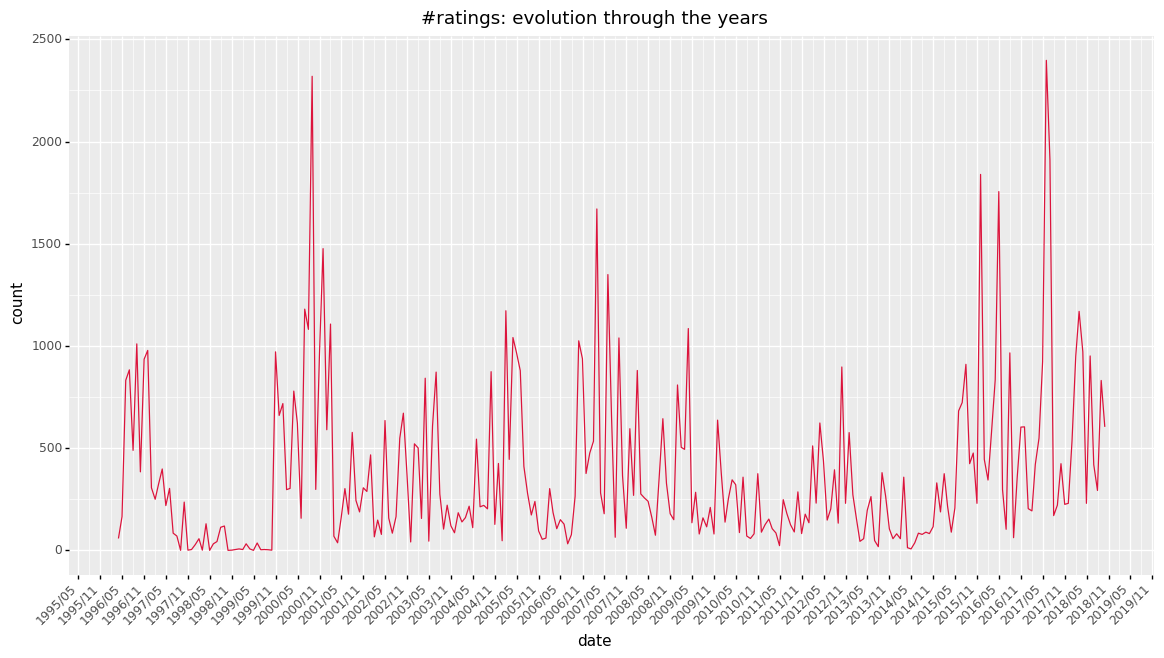

<ggplot: (8786616892847)>

In [14]:
(
    ggplot(
        movielens.groupby(pd.Grouper(key="created_at", freq="M")).count().reset_index()
    )
    + geom_line(aes(x="created_at", y="item"), color="crimson")
    + labs(x="date", y="count", title="#ratings: evolution through the years")
    + scale_x_datetime(breaks=date_breaks("6 months"), labels=date_format("%Y/%m"))
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(14, 7))
)

## Step 4

In [15]:
recsys_small = SVD(
    n_factors=4,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [16]:
recsys_large = SVD(
    n_factors=20,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [17]:
cv_results = {}

cv_results["SVD w/ 4 factors"] = cross_validate(
    recsys_small,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7630  0.7714  0.7608  0.7662  0.7597  0.7642  0.0042  
RMSE (testset)    0.8735  0.8783  0.8722  0.8754  0.8716  0.8742  0.0024  
MAE (testset)     0.6676  0.6746  0.6694  0.6682  0.6680  0.6696  0.0026  
MSE (trainset)    0.5106  0.5190  0.5171  0.5145  0.5127  0.5148  0.0030  
RMSE (trainset)   0.7146  0.7204  0.7191  0.7173  0.7160  0.7175  0.0021  
MAE (trainset)    0.5499  0.5543  0.5535  0.5519  0.5514  0.5522  0.0016  
Fit time          1.75    1.81    1.70    1.69    1.75    1.74    0.05    
Test time         0.10    0.11    0.10    0.09    0.09    0.10    0.01    


In [18]:
cv_results["SVD w/ 20 factors"] = cross_validate(
    recsys_large,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7803  0.7757  0.7793  0.7862  0.7780  0.7799  0.0035  
RMSE (testset)    0.8833  0.8807  0.8828  0.8867  0.8820  0.8831  0.0020  
MAE (testset)     0.6746  0.6781  0.6718  0.6779  0.6753  0.6755  0.0023  
MSE (trainset)    0.3020  0.3030  0.3048  0.3021  0.3046  0.3033  0.0012  
RMSE (trainset)   0.5495  0.5504  0.5521  0.5496  0.5519  0.5507  0.0011  
MAE (trainset)    0.4241  0.4242  0.4259  0.4243  0.4252  0.4247  0.0007  
Fit time          3.19    3.18    3.20    3.25    3.13    3.19    0.04    
Test time         0.10    0.09    0.10    0.10    0.10    0.10    0.00    


In [19]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE (train)"] = df["train_rmse"].map(lambda x: statistics.mean(x))

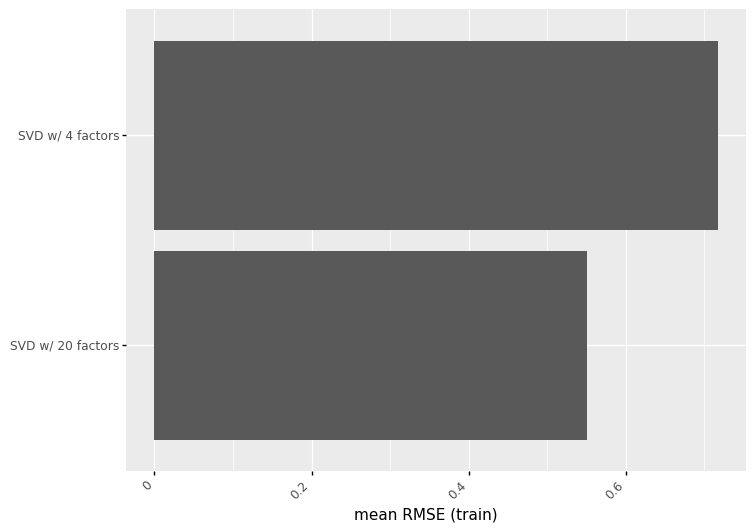

<ggplot: (8786611820523)>

In [20]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (train)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (train)")
    + coord_flip()
)

## Step 5

In [21]:
ratings = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    usecols=["user", "item", "rating"],
    names=["user", "item", "rating"],
    skiprows=1,
)

inspect_df(ratings)

shape: (100836, 3)


,user,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [22]:
ratings["user"] = ratings.groupby("user").ngroup()

In [23]:
ratings["item"] = ratings.groupby("item").ngroup()

In [24]:
def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:
    return collections.OrderedDict(
        x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [25]:
def create_tf_datasets(
    data: pd.DataFrame,
    transform_func: Callable,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_client: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["user"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    for _, user_ratings in data.groupby("user"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_client)
            .shuffle(buffer_size=max_items_per_client, seed=42)
            .batch(batch_size)
            .map(transform_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

In [26]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
    """Splits a list of user TF datasets into train/val/test by user."""
    np.random.seed(42)
    np.random.shuffle(tf_datasets)

    train_idx = int(len(tf_datasets) * train_fraction)
    val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))

    # Note that the val and test data contains completely different users, not
    # just unseen ratings from train users.
    return (
        tf_datasets[:train_idx],
        tf_datasets[train_idx:val_idx],
        tf_datasets[val_idx:],
    )

In [27]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch,
        batch_size=5,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [28]:
tf_trainsets, tf_validationsets, tf_testsets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

## Step 6

In [29]:
nest_asyncio.apply()

In [30]:
n_users = len(ratings["user"].unique())
n_items = len(ratings["item"].unique())

In [31]:
def matrix_factorization_model(
    n_users: int,
    n_items: int,
    n_latent_factors: int,
) -> tf.keras.Model:
    """A federation-friendly Matrix Factorization model."""
    combined_input = tf.keras.layers.Input(
        shape=[2], dtype="int32", name="combined_input"
    )
    u = tf.keras.layers.Embedding(
        input_dim=n_users + 1, output_dim=n_latent_factors, name="users_embedding"
    )(combined_input[:, 0])
    u = tf.keras.layers.Flatten()(u)

    i = tf.keras.layers.Embedding(
        input_dim=n_items + 1, output_dim=n_latent_factors, name="items_embedding"
    )(combined_input[:, 1])
    i = tf.keras.layers.Flatten()(i)

    output = tf.output_layer = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [i, u]
    )

    model = tf.keras.Model(inputs=combined_input, outputs=output)

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 2], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [32]:
model_fn = functools.partial(
    matrix_factorization_model,
    n_users=n_users,
    n_items=n_items,
    n_latent_factors=20,
)

In [33]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
)

In [34]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[9725,20],float32[611,20]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [35]:
state = iterative_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[-0.01610219,  0.0384602 , -0.04232321, ..., -0.01293195,
        -0.02912164, -0.04751786],
       [ 0.04701824, -0.04634982,  0.00546224, ..., -0.00814025,
         0.02869104,  0.00935537],
       [-0.02106904, -0.02493795, -0.01718439, ..., -0.01691528,
         0.04700756,  0.03215167],
       ...,
       [ 0.03579345, -0.01331761,  0.02511135, ..., -0.04699935,
        -0.04613375,  0.03063193],
       [-0.03682043,  0.0264155 , -0.00815837, ..., -0.04042209,
        -0.04578167, -0.02339491],
       [-0.02070971,  0.02077974,  0.01906634, ...,  0.02545697,
         0.0057778 ,  0.01117276]], dtype=float32), array([[-0.01925921, -0.02246243,  0.01941169, ..., -0.03697492,
         0.0331501 , -0.04877428],
       [-0.02340043, -0.04845971,  0.04753008, ...,  0.0333846 ,
         0.01057885, -0.03042316],
       [ 0.00049205,  0.04208342, -0.00084805, ..., -0.04665574,
        -0.00620506,  0.04712962],
       ...,
       [ 0.00286082, -0.03759373,  

In [36]:
print("User variables shape:", state.model.trainable[1].shape)

User variables shape: (611, 20)


In [37]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9725, 20)


In [38]:
evaluation_computation = tff.learning.build_federated_evaluation(model_fn)

In [39]:
NUM_ROUNDS = 30  # we will set up a training loop to train over multiple rounds.

In [40]:
train_losses, train_accs = [], []

state = iterative_process.initialize()

for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["root_mean_squared_error"])

Train round 0: OrderedDict([('root_mean_squared_error', 3.6591156), ('loss', 13.389128), ('num_examples', 8644), ('num_batches', 1751)])
Train round 1: OrderedDict([('root_mean_squared_error', 3.620216), ('loss', 13.105964), ('num_examples', 8908), ('num_batches', 1806)])
Train round 2: OrderedDict([('root_mean_squared_error', 3.6473722), ('loss', 13.303325), ('num_examples', 9100), ('num_batches', 1842)])
Train round 3: OrderedDict([('root_mean_squared_error', 3.6925702), ('loss', 13.635075), ('num_examples', 7853), ('num_batches', 1595)])
Train round 4: OrderedDict([('root_mean_squared_error', 3.6219757), ('loss', 13.118709), ('num_examples', 9232), ('num_batches', 1867)])
Train round 5: OrderedDict([('root_mean_squared_error', 3.681736), ('loss', 13.555181), ('num_examples', 8628), ('num_batches', 1749)])
Train round 6: OrderedDict([('root_mean_squared_error', 3.7141035), ('loss', 13.794565), ('num_examples', 9198), ('num_batches', 1861)])
Train round 7: OrderedDict([('root_mean_squ

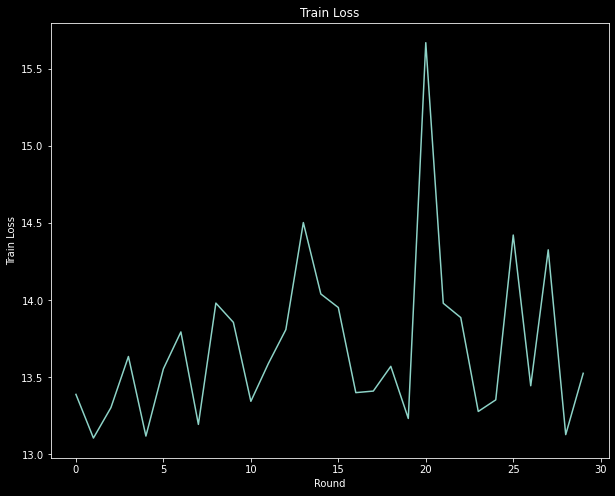

In [41]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

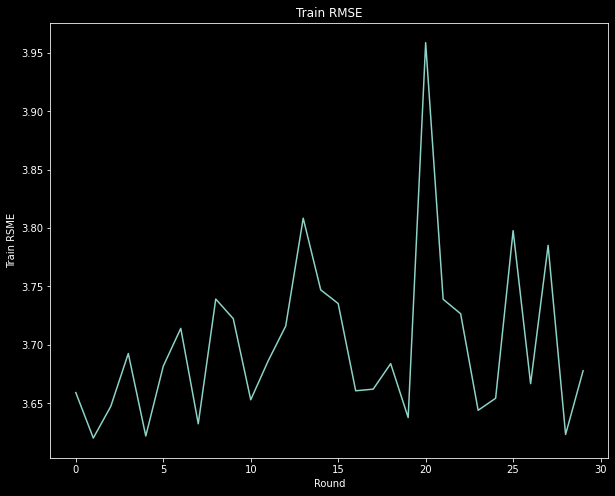

In [42]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [43]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('root_mean_squared_error', 3.7567105), ('loss', 14.112874), ('num_examples', 1038), ('num_batches', 210)])


In [44]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 3.8091698), ('loss', 14.509774), ('num_examples', 1301), ('num_batches', 264)])


## Step 7

In [45]:
def transform_batch_for_fed_prox(batch: tf.Tensor) -> collections.OrderedDict:
    """we do not need the user since each client will only look at their own data."""
    return collections.OrderedDict(
        x=tf.cast(batch[:, 1:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
    )

In [46]:
tf_datasets = [
    *create_tf_datasets(
        data=ratings,
        transform_func=transform_batch_for_fed_prox,
        batch_size=5,
        max_clients=100,
        max_items_per_client=3000,
    )
]

In [47]:
tf_trainsets, tf_validationsets, tf_testsets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

In [48]:
class UserEmbedding(tf.keras.layers.Layer):
    """Keras layer representing an embedding for a single user."""

    def __init__(self, num_latent_factors, **kwargs):
        super().__init__(**kwargs)
        self.num_latent_factors = num_latent_factors

    def build(self, input_shape):
        self.embedding = self.add_weight(
            shape=(1, self.num_latent_factors),
            initializer="uniform",
            dtype=tf.float32,
            name="UserEmbeddingKernel",
        )
        super().build(input_shape)

    def call(self, inputs):
        return self.embedding

    def compute_output_shape(self):
        return (1, self.num_latent_factors)

In [49]:
def matrix_factorization_model_with_user_embedding(
    n_items: int, n_latent_factors: int
) -> tff.learning.Model:

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

In [50]:
model_fn = functools.partial(
    matrix_factorization_model_with_user_embedding,
    n_items=n_items,
    n_latent_factors=20,
)

In [51]:
fedprox_learning_process = tff.learning.algorithms.build_unweighted_fed_prox(
    model_fn,
    proximal_strength=0.1,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
)

/home/iantonopoulos/.cache/pypoetry/virtualenvs/recommender-systems-rVb3Y5Fg-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("PartitionedCall:1", shape=(None, 20), dtype=float32), dense_shape=Tensor("PartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.


In [52]:
str(fedprox_learning_process.initialize.type_signature)

'( -> <global_model_weights=<trainable=<float32[9724,20],float32[1,20]>,non_trainable=<>>,distributor=<>,client_work=<>,aggregator=<<>,<>>,finalizer=<int64>>@SERVER)'

In [53]:
evaluation_computation = tff.learning.build_federated_evaluation(
    model_fn,
)

In [54]:
train_losses, train_mses = [], []

state = fedprox_learning_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    next_state = fedprox_learning_process.next(state, federated_train_data)
    train_losses.append(next_state.metrics["client_work"]["train"]["loss"])
    train_mses.append(
        next_state.metrics["client_work"]["train"]["root_mean_squared_error"]
    )

model_final_weights = next_state.state.global_model_weights

In [55]:
eval_metrics = evaluation_computation(model_final_weights, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('root_mean_squared_error', 19.065752), ('loss', 363.50293), ('num_examples', 1038), ('num_batches', 210)])


In [56]:
eval_metrics = evaluation_computation(model_final_weights, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('root_mean_squared_error', 20.177681), ('loss', 407.13882), ('num_examples', 1301), ('num_batches', 264)])


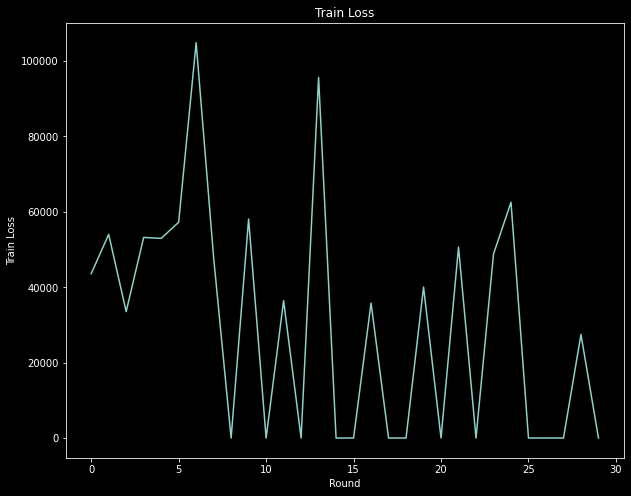

In [57]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

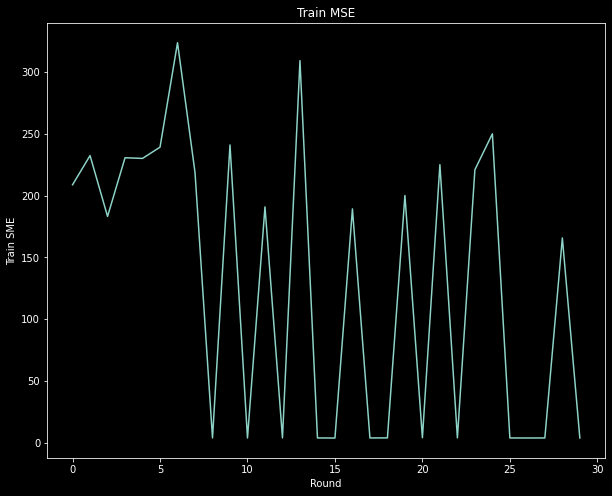

In [58]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_mses)
plt.ylabel("Train SME")
plt.xlabel("Round")
plt.title("Train MSE")
plt.show()

## Step 8

In [59]:
def get_matrix_factorization_reconstruction_model(
    n_items: int, n_latent_factors: int
) -> tff.learning.reconstruction.Model:
    """Defines a Keras matrix factorization model."""
    # layers with variables will be partitioned into global and local layers.
    global_layers = []
    local_layers = []

    item_input = tf.keras.layers.Input(shape=[1], name="Item")
    item_embedding_layer = tf.keras.layers.Embedding(
        n_items, n_latent_factors, name="ItemEmbedding"
    )
    global_layers.append(item_embedding_layer)
    flat_item_vec = tf.keras.layers.Flatten(name="FlattenItems")(
        item_embedding_layer(item_input)
    )

    user_embedding_layer = UserEmbedding(n_latent_factors, name="UserEmbedding")
    local_layers.append(user_embedding_layer)

    flat_user_vec = user_embedding_layer(item_input)

    pred = tf.keras.layers.Dot(1, normalize=False, name="Dot")(
        [flat_user_vec, flat_item_vec]
    )

    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, 1], dtype=tf.int64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
    )

    model = tf.keras.Model(inputs=item_input, outputs=pred)

    return tff.learning.reconstruction.from_keras_model(
        keras_model=model,
        global_layers=global_layers,
        local_layers=local_layers,
        input_spec=input_spec,
    )

In [60]:
model_fn = functools.partial(
    get_matrix_factorization_reconstruction_model, n_items=n_items, n_latent_factors=20
)

In [61]:
class RatingAccuracy(tf.keras.metrics.Mean):
    """Keras metric computing accuracy of reconstructed ratings."""

    def __init__(self, name: str = "rating_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)

    def update_state(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None,
    ):
        absolute_diffs = tf.abs(y_true - y_pred)
        # A [batch_size, 1] tf.bool tensor indicating correctness within the
        # threshold for each example in a batch. A 0.5 threshold corresponds
        # to correctness when predictions are rounded to the nearest whole
        # number.
        example_accuracies = tf.less_equal(absolute_diffs, 0.5)
        super().update_state(example_accuracies, sample_weight=sample_weight)

In [62]:
loss_fn = lambda: tf.keras.losses.MeanSquaredError()
metrics_fn = lambda: [RatingAccuracy()]

In [63]:
training_process = tff.learning.reconstruction.build_training_process(
    model_fn=model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.5),
    reconstruction_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.1),
)

In [64]:
evaluation_computation = tff.learning.reconstruction.build_federated_evaluation(
    model_fn,
    loss_fn=loss_fn,
    metrics_fn=metrics_fn,
    reconstruction_optimizer_fn=functools.partial(tf.keras.optimizers.SGD, 0.1),
)

In [65]:
state = training_process.initialize()

print(state.model)

ModelWeights(trainable=[array([[ 0.03654129,  0.03974691,  0.00293901, ..., -0.02807034,
         0.04045601, -0.01693328],
       [ 0.04455861, -0.04506457, -0.01283772, ..., -0.0007038 ,
         0.00842126, -0.00450841],
       [-0.03444583, -0.03072172,  0.0025114 , ...,  0.02017796,
        -0.02217284, -0.04320771],
       ...,
       [-0.02686139, -0.01103271,  0.00393469, ...,  0.048394  ,
        -0.04751729, -0.00896676],
       [-0.03507924,  0.00664278, -0.04838902, ..., -0.02399396,
         0.03446916, -0.02485747],
       [-0.01786835,  0.00626576, -0.03461463, ...,  0.03660465,
         0.02270095,  0.00482101]], dtype=float32)], non_trainable=[])


In [66]:
print("Item variables shape:", state.model.trainable[0].shape)

Item variables shape: (9724, 20)


In [67]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)

In [68]:
print("Initial Eval:", eval_metrics["eval"])

Initial Eval: OrderedDict([('loss', 14.362386), ('rating_accuracy', 0.025390625)])


In [69]:
federated_train_data = np.random.choice(tf_trainsets, size=50, replace=False).tolist()
state, metrics = training_process.next(state, federated_train_data)

In [70]:
print(f"Train metrics:", metrics["train"])

Train metrics: OrderedDict([('rating_accuracy', 0.003787879), ('loss', 13.020618)])


In [71]:
train_losses, train_accs = [], []

state = training_process.initialize()

# This may take a couple minutes to run.
for i in range(NUM_ROUNDS):
    federated_train_data = np.random.choice(
        tf_trainsets, size=50, replace=False
    ).tolist()
    state, metrics = training_process.next(state, federated_train_data)
    print(f"Train round {i}:", metrics["train"])
    train_losses.append(metrics["train"]["loss"])
    train_accs.append(metrics["train"]["rating_accuracy"])

Train round 0: OrderedDict([('rating_accuracy', 0.003854493), ('loss', 13.5359535)])
Train round 1: OrderedDict([('rating_accuracy', 0.0036124096), ('loss', 13.279842)])
Train round 2: OrderedDict([('rating_accuracy', 0.010842369), ('loss', 12.09217)])
Train round 3: OrderedDict([('rating_accuracy', 0.058746394), ('loss', 8.913105)])
Train round 4: OrderedDict([('rating_accuracy', 0.13388853), ('loss', 5.7472777)])
Train round 5: OrderedDict([('rating_accuracy', 0.20135576), ('loss', 5.2958665)])
Train round 6: OrderedDict([('rating_accuracy', 0.24834268), ('loss', 4.1782846)])
Train round 7: OrderedDict([('rating_accuracy', 0.27562216), ('loss', 3.5731504)])
Train round 8: OrderedDict([('rating_accuracy', 0.20598911), ('loss', 3.8316135)])
Train round 9: OrderedDict([('rating_accuracy', 0.3112045), ('loss', 2.9248536)])


2022-03-20 13:53:31.660356: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Train round 10: OrderedDict([('rating_accuracy', 0.35499284), ('loss', 2.5180745)])
Train round 11: OrderedDict([('rating_accuracy', 0.30475932), ('loss', 2.4890177)])
Train round 12: OrderedDict([('rating_accuracy', 0.347525), ('loss', 2.378248)])
Train round 13: OrderedDict([('rating_accuracy', 0.373588), ('loss', 2.0814757)])
Train round 14: OrderedDict([('rating_accuracy', 0.30905014), ('loss', 2.3447592)])
Train round 15: OrderedDict([('rating_accuracy', 0.35855004), ('loss', 2.18203)])
Train round 16: OrderedDict([('rating_accuracy', 0.38782817), ('loss', 1.942053)])
Train round 17: OrderedDict([('rating_accuracy', 0.31689548), ('loss', 2.232474)])
Train round 18: OrderedDict([('rating_accuracy', 0.30921644), ('loss', 2.3547544)])
Train round 19: OrderedDict([('rating_accuracy', 0.4054768), ('loss', 1.7049944)])
Train round 20: OrderedDict([('rating_accuracy', 0.42860648), ('loss', 1.6808853)])
Train round 21: OrderedDict([('rating_accuracy', 0.3937083), ('loss', 1.6857765)])
Tra

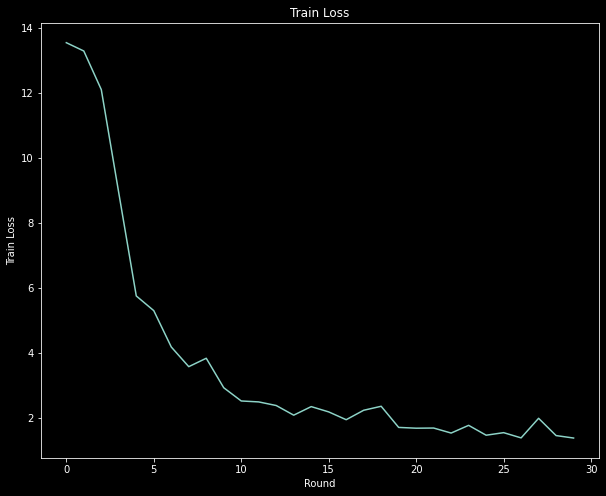

In [72]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_losses)
plt.ylabel("Train Loss")
plt.xlabel("Round")
plt.title("Train Loss")
plt.show()

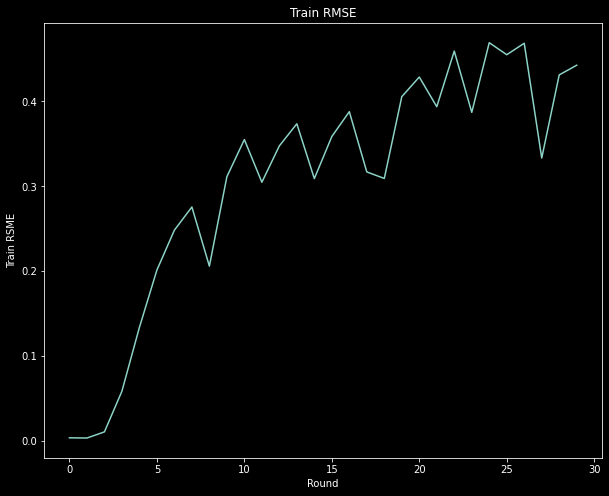

In [73]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = [10, 8]
plt.plot(range(NUM_ROUNDS), train_accs)
plt.ylabel("Train RSME")
plt.xlabel("Round")
plt.title("Train RMSE")
plt.show()

In [74]:
eval_metrics = evaluation_computation(state.model, tf_validationsets)
print("Final Eval:", eval_metrics["eval"])

Final Eval: OrderedDict([('loss', 3.1276536), ('rating_accuracy', 0.27539062)])


In [75]:
eval_metrics = evaluation_computation(state.model, tf_testsets)
print("Final Test:", eval_metrics["eval"])

Final Test: OrderedDict([('loss', 2.7731032), ('rating_accuracy', 0.24175824)])


## Step 9

In [76]:
# already incorporated in previous steps

## Step 10